# Simulaciones de trayectorías (plásticos)


## Introducción

Comprender las trayectorias en el océano es importante para varias aplicaciones, como la contaminación marina por plásticos, pero también para otros contaminantes oceánicos como los derrames de petróleo o para estudios de ecología marina para comprender la conectividad de las especies marinas. Las simulaciones Lagrangianas son una  herramienta potente para obtener trayectorias marinas. Una de las herramientas de software abierto que existen es OceanParcels. Usando como entrada campos de velocidad, como los que vimos en el tutorial anterior (por ejemplo, productos altimetría satelital de la superficie del mar), podemos obtener fácilmente trayectorias de partículas con diferentes características.

<!-- Here will look at an example of a Lagrangian simulation..... -->

¿Quieres saber más detalles sobre OceanParcels? Más info. [aquí].(https://docs.oceanparcels.org/en/latest/index.html)


También puede explorar el simulador en línea [plastic adrift](https://plasticadrift.org/)!!

## ¿Cómo funciona?

### Características de la simulación:
* Duración (runtime): 30 días
* Número de partículas: 144 (1 por punto de malla en nuestra subregión de estudio)

In [1]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [ ]:
# from urllib.request import urlretrieve 

# currentfile = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.nc"

# if not(os.path.exists(currentfile)):
#     urlretrieve("https://dox.uliege.be/index.php/s/mZLCV3TIbqr1Vqw/download", currentfile)

# datacurrent = xr.open_dataset(currentfile)
# datacurrent

# lon2d, lat2d = np.meshgrid(datacurrent["longitude"].values, datacurrent["latitude"].values)
# u =  datacurrent["uo"][0,0,:,:]
# v =  datacurrent["vo"][0,0,:,:]
# magnitude = (u ** 2 + v ** 2) ** 0.5

# Campos de entrada (input fields):

Usaremos los campos de velocidad de .. We will use the L4 dataset again.

In [8]:
filedir = '/Users/Gomez023/Downloads/'#'../content/drive/MyDrive/Altimetry/L4/'

In [9]:
!ls -trl /Users/Gomez023/Downloads/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.n

ls: /Users/Gomez023/Downloads/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.n: No such file or directory


## Primero cargamos un fichero de ejemplo::

In [11]:
ds_m = xr.open_dataset(filedir + "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.nc")

In [12]:
ds_m

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 481, longitude: 840, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2024-11-24
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 -20.0 -19.92 -19.83 ... 19.83 19.92 20.0
  * longitude  (longitude) float32 -140.0 -139.9 -139.8 ... -70.25 -70.17 -70.08
Data variables:
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202406
    subset:date:       2024-11-15T13:53:00.715Z

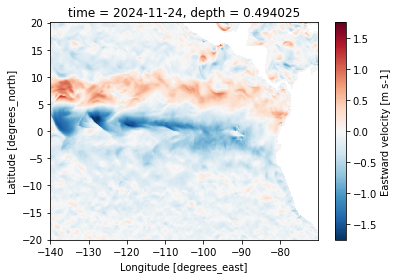

In [13]:
ds_m.uo[0,0,:,:].plot()

## Seleccionamos una subzona:

In [21]:
lon_min = -100
lon_max = -75
lat_min = 2
lat_max = 10

In [22]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


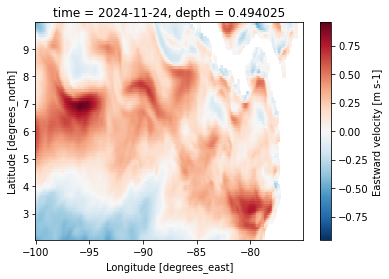

In [23]:
ds_m_sub.uo[0,0,:,:].plot()

## Cargamos el "fieldset" (campo de velocidad) para las simulaciones:

In [ ]:
ficheros = {'U': filedir + "dt_europe_allsat_phy_l4_2023020[1-9]_20231013.nc",
             'V': filedir + "dt_europe_allsat_phy_l4_2023020[1-9]_20231013.nc"}



### Usamos la velocidad Euleriana, así que elegimos las variables ugos y vgos:

In [ ]:
variables = {'U': 'ugos',
             'V': 'vgos'}

dimensiones = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [ ]:
fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, deferred_load=False)

# Definimos los parámetros de la simulación:

## ¿Cuántas y dónde queremos lanzar las partículas?

### Opción A) Definimos las longitudes y latitudes.
### Por ejemple, lanzamos las partículas sobre una línea:

In [1]:
lat1D = np.arange(5, 6, .1) # (inicio, fin + incremento, incremento)
lon1D = np.ones_like(lat1D) * -81.

# pset_A = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon1D, lat=lat1D)


NameError: name 'np' is not defined

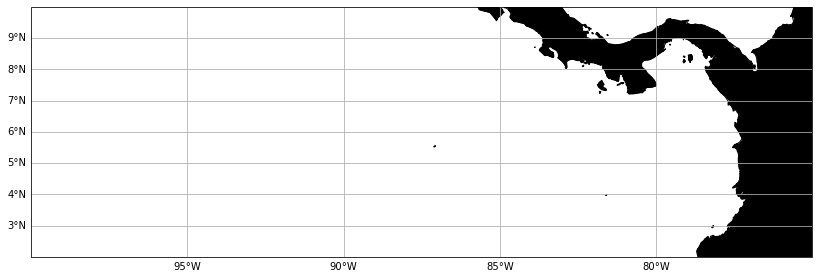

In [25]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
# ax1.scatter(pset_A.lon, pset_A.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### Opción B) Lanzamos 1 partícula en cada punto de malla del "fieldset"


In [ ]:
lon1D = fieldset.U.lon[np.arange(260, 270, 1)]
lat1D = fieldset.U.lat[np.arange(140, 150, 1)]

lons, lats = np.meshgrid(lon1D, lat1D)
pset_B = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)


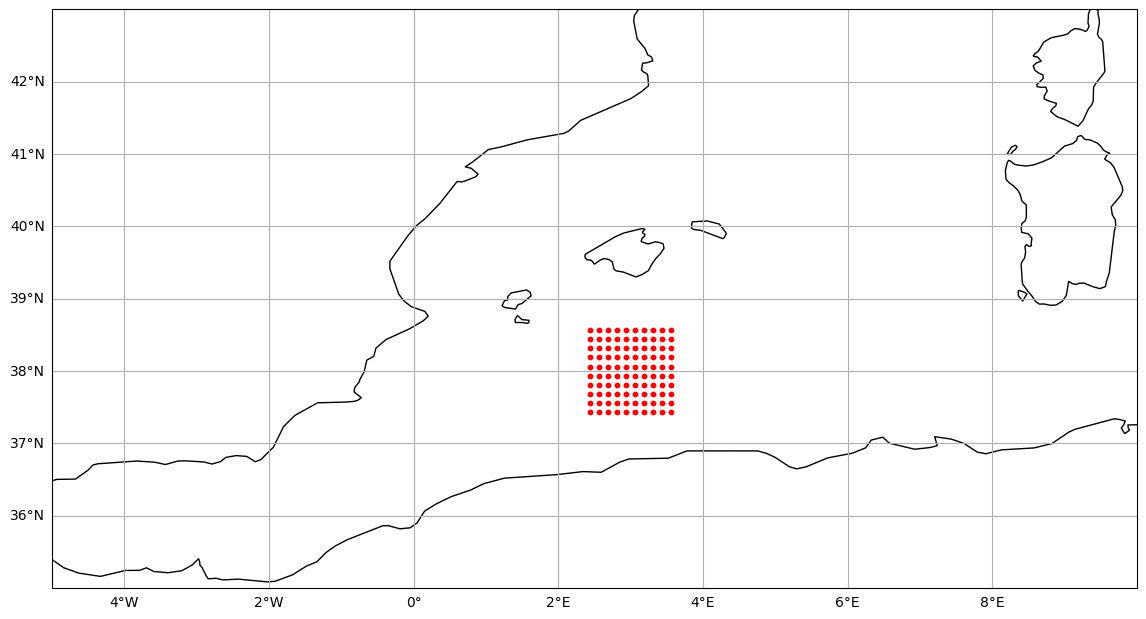

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_B.lon, pset_B.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Otros parámetros:

In [ ]:
runtime_days = 5

In [ ]:
fichero_salida = "lag_simu_pset_A_test01.zarr"

In [ ]:

output_file = pset_A.ParticleFile(name=fichero_salida, outputdt=timedelta(hours=24))
pset_A.execute(pset_A.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_A_test01.zarr.


INFO:parcels.tools.loggers:Output files are stored in lag_simu_pset_A_test01.zarr.


100%|██████████| 432000.0/432000.0 [00:00<00:00, 614451.46it/s]


# Echemos un vistazo a las trayectorias generadas:

In [ ]:
ds = xr.open_dataset(output_filename)

/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [ ]:
ds

<xarray.Dataset> Size: 2kB
Dimensions:     (trajectory: 17, obs: 5)
Coordinates:
  * obs         (obs) int32 20B 0 1 2 3 4
  * trajectory  (trajectory) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Data variables:
    lat         (trajectory, obs) float32 340B ...
    lon         (trajectory, obs) float32 340B ...
    time        (trajectory, obs) datetime64[ns] 680B ...
    z           (trajectory, obs) float32 340B ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.0.6

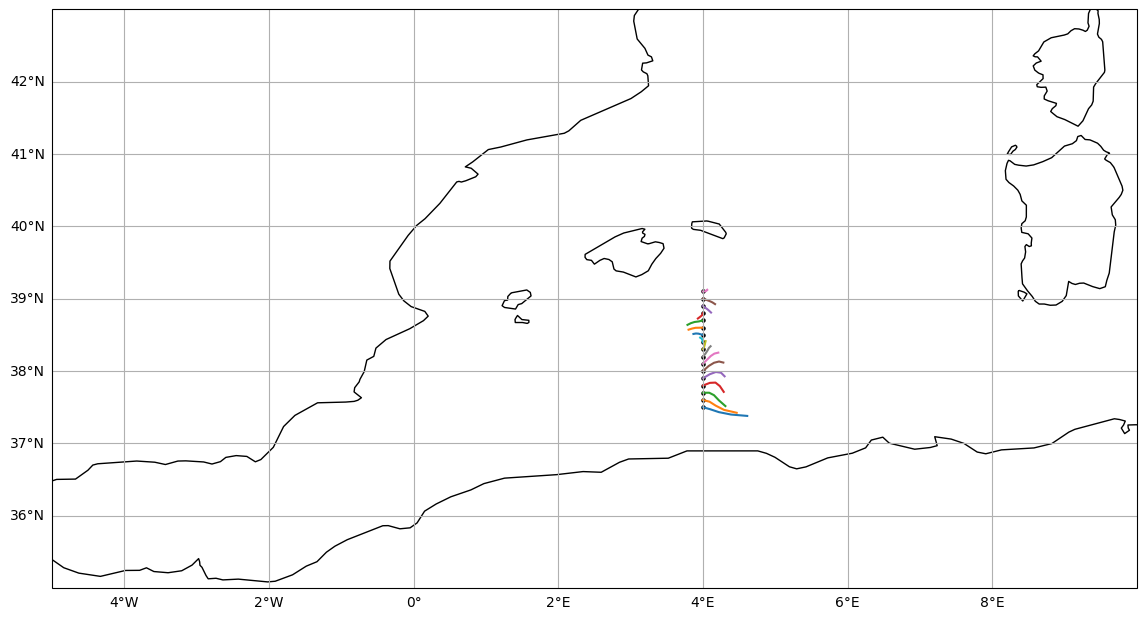

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Graficamos las partículas en el último paso de tiempo con la velocidad zonal de fondo:

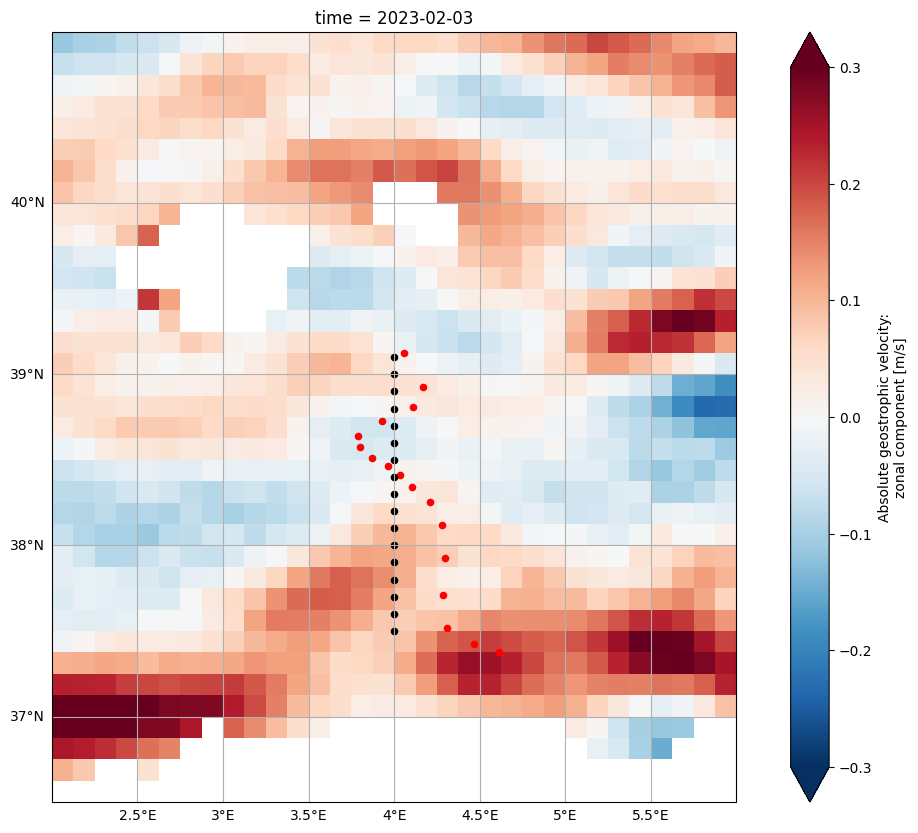

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.ugos[0,:,:].plot(vmin=-.3, vmax=.3, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([2, 6])
ax1.set_ylim([36.5, 41])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Referencias

Laura Gomez-Navarro, & Paul Hargous. (2024). IMEDEA-AP-LAB/MASS24_Altimetry_tutorial: v1.0.0 (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.13962687